### Importações

In [1]:
import os
import joblib
import pandas as pd
import matplotlib.pyplot as plt

# Modelos e Validação
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import (
    StandardScaler, LabelEncoder, OrdinalEncoder, OneHotEncoder
)
from sklearn.decomposition import PCA
from sklearn.metrics import (
    fbeta_score, make_scorer, 
    roc_auc_score, confusion_matrix, ConfusionMatrixDisplay, 
    accuracy_score, precision_score, recall_score
)

# Reamostragem (Oversampling/Undersampling)
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE, RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

### Carregar Datasets e Output

In [ ]:
output_path = "../../Models/XGBoost_Models"

datasets = {
    "Base": pd.read_csv('../../Data/risco_cardiovascular_base.csv'),
    "Features": pd.read_csv('../../Data/risco_cardiovascular_features.csv')
}

### Métrica Customizada

Para este problema, definimos o **F2-Score** como Métrica de Rankeamento.

$$F_2 = (1 + 2^2) \cdot \frac{\text{precision} \cdot \text{recall}}{(2^2 \cdot \text{precision}) + \text{recall}}$$

- O peso $\beta=2$ faz com que o modelo busque identificar o máximo de pacientes em risco (alto Recall), mesmo que isso gere alguns alarmes falsos adicionais.

In [3]:
f2_scorer = make_scorer(fbeta_score, beta=2, average='macro')

### Definição de Hiperparâmetros para GridSearch

In [ ]:
resampler = [
    SMOTE(random_state=42),
    RandomOverSampler(random_state=42),
    RandomUnderSampler(random_state=42),
    'passthrough'
]

model_config = {
  'XGBoost': {
    'model': XGBClassifier(random_state=42, eval_metric='mlogloss'),
    'params': {
      'resampler': resampler,
      'classifier__n_estimators': [50, 100],
      'classifier__learning_rate': [0.01, 0.1],
      'classifier__max_depth': [None, 3, 5]
    }
  }
}

## Loop de Treinamento

O pré-processamento é automatizado via *ColumnTransformer*:

- Ordinal Encoding: Aplicado à categoria de IMC (BMI), preservando a hierarquia natural.
- Standard Scaling: Normalização de variáveis numéricas.
- One-Hot Encoding: Transformação de variáveis categóricas nominais.

Para cada dataset (**Base** e **Features**), o `GridSearchCV` avaliará as seguintes combinações:

1.  **Balanceamento de Dados:** Comparação entre `SMOTE`, `RandomOverSampler`, `RandomUnderSampler` e a permanência dos dados originais (`passthrough`).

2.  **Redução de Dimensionalidade:** Avaliação do impacto do `PCA` (mantendo 95% da variância) versus o uso de todas as colunas originais (`None`).
3.  **Otimização do XGBoost:** Ajuste simultâneo de profundidade e taxa de aprendizado.

> Isso nos permite identificar se o ganho de performance vem da engenharia de atributos, do tratamento estatístico do desbalanceamento ou da arquitetura do algoritmo.

In [5]:
model_save_path = output_path
os.makedirs(model_save_path, exist_ok=True)

results_list = []

for ds_name, df in datasets.items():
    print(f"\n>>> Processando Dataset: {ds_name}")
    df_clean = df.copy()
  
    # Preparação Features e Target
    X = df_clean.drop('BP_Category', axis=1)
    le = LabelEncoder()
    y = le.fit_transform(df_clean['BP_Category'])

    # Encoding das Features
    bmi_order = ["Underweight", "Normal Weight", "Overweight", "Obese"]
    bmi_col = ["BMI Category"]

    cat_cols = [c for c in X.select_dtypes(include=['object']).columns if c != "BMI Category"]
    num_cols = X.select_dtypes(exclude=['object']).columns.tolist()

    preprocessor = ColumnTransformer(transformers=[
        ('ordinal', OrdinalEncoder(categories=[bmi_order]), bmi_col),
        ('numeric', StandardScaler(), num_cols),
        ('categories', OneHotEncoder(handle_unknown='ignore'), cat_cols)
    ])

    # Divisão treino/teste com estratificação
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

    for model_name, config in model_config.items():
      print(f"\n--- Iniciando GridSearch para {model_name} ---")

      # Imblearn para garantir que o SMOTE ocorra apenas no conjunto de treino
      pipeline = ImbPipeline(steps=[
        ('preprocessor', preprocessor),
        ('resampler', SMOTE()),
        ('pca', PCA()),
        ('classifier', config['model'])
      ])

      cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

      grid = GridSearchCV(
          pipeline,
          config['params'],
          cv=cv,
          scoring={'f2': f2_scorer, 'accuracy': 'accuracy'},
          refit='f2', # O melhor modelo será escolhido pelo F2-Score
          n_jobs=-1
      )

      grid.fit(X_train, y_train)

      # Predições de Teste
      y_pred = grid.predict(X_test)
      y_proba = grid.predict_proba(X_test)

      # Métricas de Desempenho
      metrics = {
        'Model': model_name,
        'Dataset': ds_name,
        'Best_Params': grid.best_params_,
        'PCA_Used': grid.best_params_.get('pca__n_components') is not None,
        'SMOTE_Used': not isinstance(grid.best_params_.get('resampler'), str),

        'Train_CV_F2': grid.best_score_,
        'Test_F2': fbeta_score(y_test, y_pred, beta=2, average='macro'),
        'Overfitting_Gap': grid.best_score_ - fbeta_score(y_test, y_pred, beta=2, average='macro'),

        'Test_Recall': recall_score(y_test, y_pred, average='macro'),
        'Test_Precision': precision_score(y_test, y_pred, average='macro'),
        'Test_Acc': accuracy_score(y_test, y_pred),
        'Test_AUC': roc_auc_score(y_test, y_proba, multi_class='ovr', average='weighted')
      }

      results_list.append(metrics)

      joblib.dump(grid.best_estimator_, os.path.join(model_save_path, f"{model_name}_{ds_name}.pkl"))


>>> Processando Dataset: Base

--- Iniciando GridSearch para XGBoost ---


/tmp/ipykernel_527/3196768571.py:19: Pandas4Warning: For backward compatibility, 'str' dtypes are included by select_dtypes when 'object' dtype is specified. This behavior is deprecated and will be removed in a future version. Explicitly pass 'str' to `include` to select them, or to `exclude` to remove them and silence this warning.
See https://pandas.pydata.org/docs/user_guide/migration-3-strings.html#string-migration-select-dtypes for details on how to write code that works with pandas 2 and 3.
  cat_cols = [c for c in X.select_dtypes(include=['object']).columns if c != "BMI Category"]
/home/gabriel/Documents/CardiopatiaModel/venv/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [13:17:49] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/gabriel/Documents/CardiopatiaModel/venv/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [13:17:49] WARNING: /workspace/s


>>> Processando Dataset: Features

--- Iniciando GridSearch para XGBoost ---


/tmp/ipykernel_527/3196768571.py:19: Pandas4Warning: For backward compatibility, 'str' dtypes are included by select_dtypes when 'object' dtype is specified. This behavior is deprecated and will be removed in a future version. Explicitly pass 'str' to `include` to select them, or to `exclude` to remove them and silence this warning.
See https://pandas.pydata.org/docs/user_guide/migration-3-strings.html#string-migration-select-dtypes for details on how to write code that works with pandas 2 and 3.
  cat_cols = [c for c in X.select_dtypes(include=['object']).columns if c != "BMI Category"]
/home/gabriel/Documents/CardiopatiaModel/venv/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [13:18:21] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/gabriel/Documents/CardiopatiaModel/venv/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [13:18:21] WARNING: /workspace/s

### Resultados

In [6]:
# Melhor resultado para cada Dataset (Ordenado pelo F2-Score)
pd.set_option("display.max_colwidth", None)

metrics_save_path = os.path.join(output_path, "Metrics")
os.makedirs(metrics_save_path, exist_ok=True)

df_results = pd.DataFrame(results_list)
df_results = df_results.sort_values(by='Test_F2', ascending=False)

print("\n--- COMPARATIVO DE PERFORMANCE ---")

for model_name in model_config.keys():
    df_model = df_results[df_results["Model"] == model_name].copy()

    filename = f"resultado_final_{model_name}.csv"
    df_model.to_csv(os.path.join(metrics_save_path, filename), index=False)
    
    print(f"\n--- Tabela Final: {model_name} ---")
    display(df_model[
        ['Dataset', 'Train_CV_F2', 'Test_F2', 'Overfitting_Gap', 'Test_Recall', 'Test_Precision', 'Test_AUC', 'PCA_Used', 'SMOTE_Used']
    ])

print(f"\nProcesso concluído! Os arquivos foram salvos em: {metrics_save_path}")


--- COMPARATIVO DE PERFORMANCE ---

--- Tabela Final: XGBoost ---


,Dataset,Train_CV_F2,Test_F2,Overfitting_Gap,Test_Recall,Test_Precision,Test_AUC,PCA_Used,SMOTE_Used
0,Base,0.977850,0.935208,0.042641,0.936364,0.931341,0.994484,False,True
1,Features,0.970867,0.914747,0.056120,0.914646,0.919613,0.962137,True,True



Processo concluído! Os arquivos foram salvos em: ../../Model/XGBoost_Models/Metrics


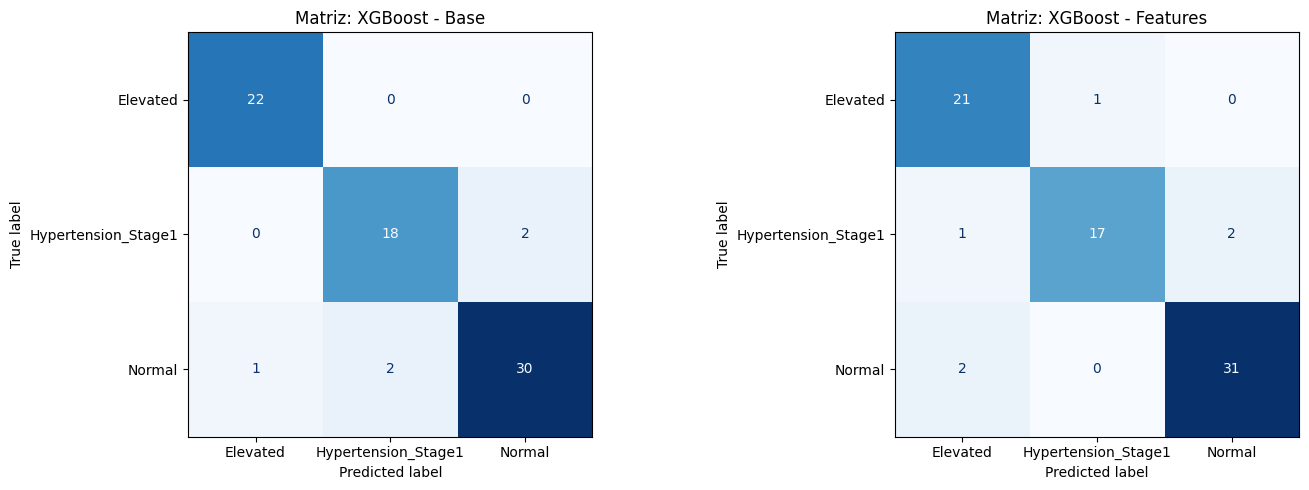

In [7]:
# Matriz de Confusão (Visualização da precisão e recall do modelo)

fig, axes = plt.subplots(1, 2, figsize=(15, 5))

for i, res in enumerate(results_list[:2]): # Pega os melhores de cada dataset
    model = joblib.load(os.path.join(model_save_path, f"{res['Model']}_{res['Dataset']}.pkl"))

    y_pred = model.predict(X_test)

    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.classes_)
    disp.plot(ax=axes[i], cmap='Blues', colorbar=False)
    axes[i].set_title(f"Matriz: {res['Model']} - {res['Dataset']}")

plt.tight_layout()
plt.show()

### Visualização de *Feature Importance*

O gráfico abaixo utiliza o critério de Ganho (Gain) do XGBoost. O Ganho mede a melhoria relativa na precisão trazida por uma característica ao criar os ramos da árvore. Variáveis com maior ganho são as que mais contribuem para a diferenciação dos níveis de pressão arterial.

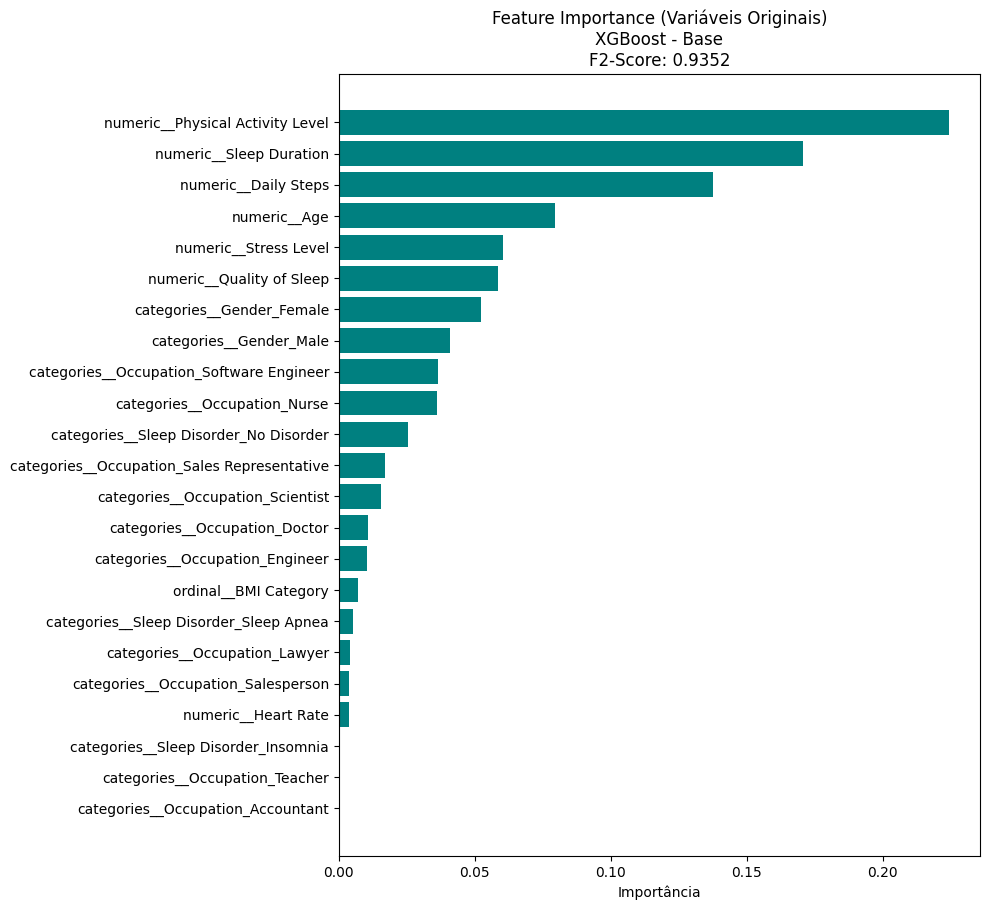

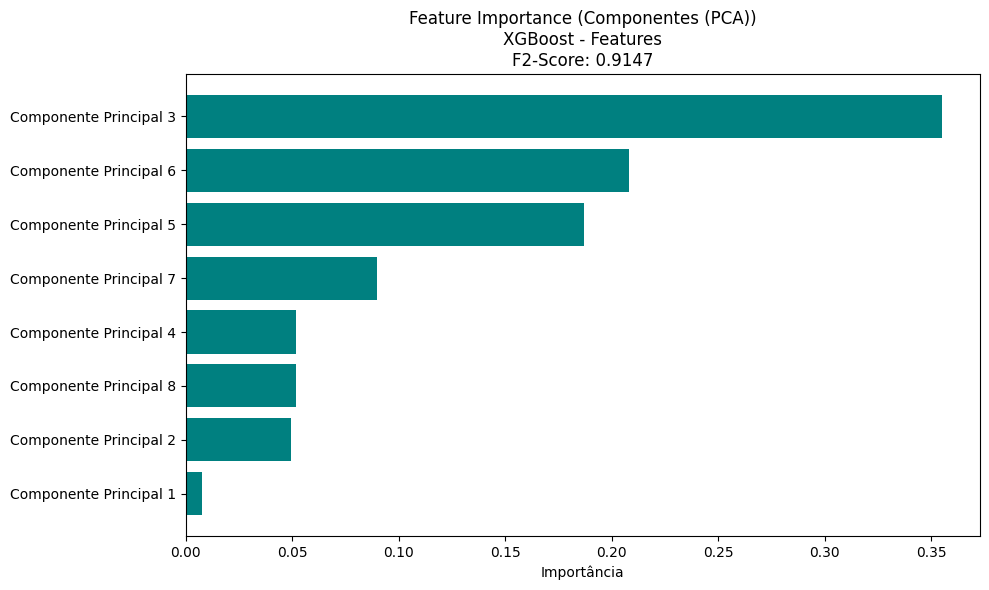

In [ ]:
# melhor modelo de cada dataset baseado no Test_F2
best_per_ds = pd.DataFrame(results_list).sort_values('Test_F2', ascending=False).drop_duplicates('Dataset')

for index, row in best_per_ds.iterrows():
    # Carregar o modelo salvo
    model_path = os.path.join(model_save_path, f"{row['Model']}_{row['Dataset']}.pkl")
    pipeline = joblib.load(model_path)

    # Extrair o nome do dataset e das features
    xgb_model = pipeline.named_steps['classifier']
    importances = xgb_model.feature_importances_

    feature_names = pipeline.named_steps['preprocessor'].get_feature_names_out()
    label_set = "Variáveis Originais"

    # Criar Dataframe Gráfico
    df_imp = pd.DataFrame({
        'Feature': feature_names, 
        'Importance': importances
    }).sort_values(by='Importance', ascending=True)


    # Extrair a importância nativa (Ganho/Gain)
    df_imp = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
    df_imp = df_imp.sort_values(by='Importance', ascending=True)

    plt.figure(figsize=(10, 0.4 * len(df_imp)))
    plt.barh(df_imp['Feature'], df_imp['Importance'], color='teal')
    plt.title(f"Feature Importance ({label_set})\n{row['Model']} - {row['Dataset']}\nF2-Score: {row['Test_F2']:.4f}")
    plt.xlabel("Importância")
    
    plt.tight_layout()
    plt.show()